In [1]:
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from azure.storage.blob import BlobServiceClient

In [2]:
import src.paychex_ml as pml
from src.paychex_ml.utils import load_credentials

In [3]:
credentials = load_credentials("blob_storage",
                               file="C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast/credentials.yml")

In [4]:
# Start client
container_name = "clean-data"
blob_service_client = BlobServiceClient.from_connection_string(credentials['conn_string'])
container_client = blob_service_client.get_container_client(container_name)

In [5]:
# Download file
file = 'paychex_revenue.parquet'
stream_downloader = container_client.download_blob(file)
stream = BytesIO()
stream_downloader.readinto(stream)

30519

In [6]:
df = pd.read_parquet(stream, engine='pyarrow')

In [39]:
df_month = df[df['00 period']!=0].loc[('Actual','Final Revised'),:].reset_index()

C:\Users\bruno.gonzalez\Miniconda3\envs\azml\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [40]:
df_month['index'] = pd.to_datetime(df_month['00 period'].apply(str) + df_month['index'].str.slice(2), format="%m%y")\
    .dt.to_period('M')

In [41]:
period = df_month.pop('00 period')

In [42]:
df_month = df_month.set_index('index')

In [43]:
df_month.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 84 entries, 2015-01 to 2021-12
Freq: M
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   11 Payroll Blended Products   84 non-null     float64
 1   12 W2 Revenue                 84 non-null     float64
 2   13 Delivery Revenue           84 non-null     float64
 3   14 ASO Allocation             84 non-null     float64
 4   15 Other Processing Revenue   84 non-null     float64
 5   16 SurePayroll                84 non-null     float64
 6   17 Total International        84 non-null     float64
 7   20 Total 401k                 84 non-null     float64
 8   31 HR Solutions (excl PEO)    84 non-null     float64
 9   40 Total Online Services      84 non-null     float64
 10  50 Other Managment Solutions  84 non-null     float64
 11  60 Total PEO                  84 non-null     float64
 12  70 Total Insurance Services   84 non-null     

In [44]:
df_month.describe()

,11 Payroll Blended Products,12 W2 Revenue,13 Delivery Revenue,14 ASO Allocation,15 Other Processing Revenue,16 SurePayroll,17 Total International,20 Total 401k,31 HR Solutions (excl PEO),40 Total Online Services,50 Other Managment Solutions,60 Total PEO,70 Total Insurance Services
count,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01
mean,1.084483e+08,7.958609e+06,1.003312e+07,1.078326e+07,6.234125e+06,5.098309e+06,2.146622e+06,1.909759e+07,3.140326e+07,1.297825e+07,1.492398e+07,3.910678e+07,1.395553e+07
std,9.354400e+06,2.108662e+07,3.986742e+06,2.195401e+06,1.178364e+06,1.554469e+06,1.438746e+06,2.662763e+06,6.162351e+06,2.019918e+06,4.726722e+06,2.225136e+07,2.243022e+06
min,9.094933e+07,-2.419720e+05,6.185802e+06,7.011292e+06,3.790476e+06,3.221739e+06,6.728264e+05,1.478393e+07,2.028845e+07,8.581821e+06,6.350954e+06,1.294870e+07,1.008407e+07
25%,1.002485e+08,1.814661e+05,7.443607e+06,9.259447e+06,5.411902e+06,4.032447e+06,8.211894e+05,1.685675e+07,2.703527e+07,1.159864e+07,1.352016e+07,1.980987e+07,1.227636e+07
50%,1.070092e+08,3.135933e+05,8.252243e+06,1.035877e+07,6.132526e+06,4.729663e+06,1.034863e+06,1.894864e+07,3.014123e+07,1.330167e+07,1.529533e+07,3.146800e+07,1.411706e+07
75%,1.155139e+08,7.512116e+06,1.198190e+07,1.235705e+07,6.765924e+06,5.801675e+06,3.577341e+06,2.111923e+07,3.589550e+07,1.441724e+07,1.766897e+07,6.466603e+07,1.554356e+07
max,1.286676e+08,9.538279e+07,2.254830e+07,1.605370e+07,1.006668e+07,1.208089e+07,4.400806e+06,2.463041e+07,4.576697e+07,1.724580e+07,2.757900e+07,8.755024e+07,2.207968e+07


# Time series plots

11 Payroll Blended Products


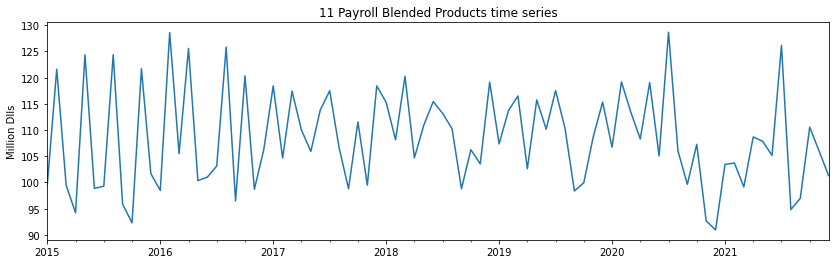

12 W2 Revenue


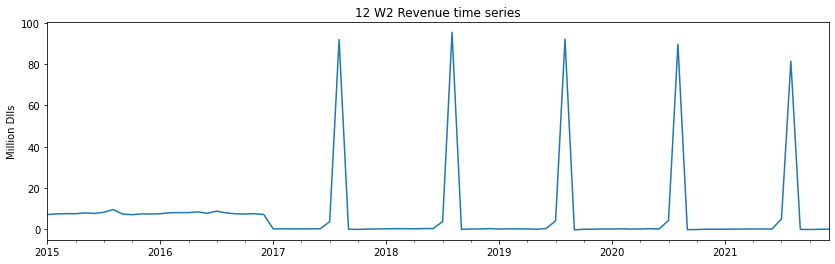

13 Delivery Revenue


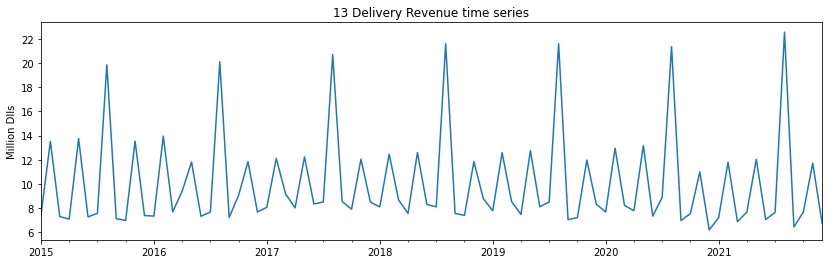

14 ASO Allocation


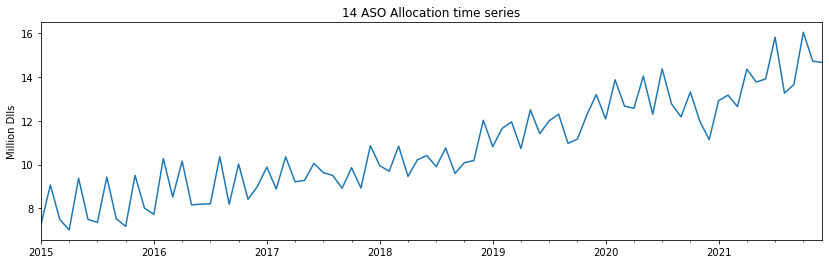

15 Other Processing Revenue


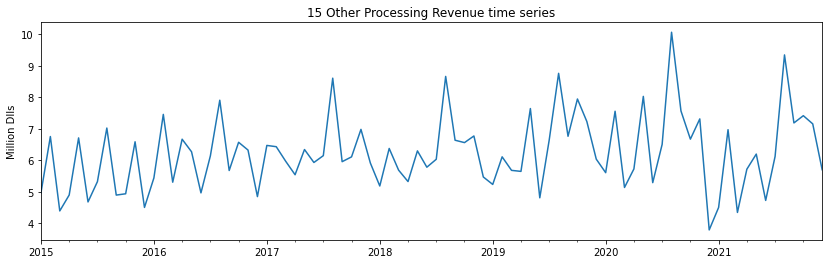

16 SurePayroll


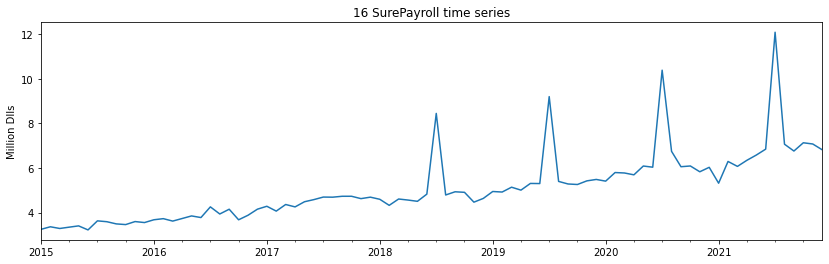

17 Total International


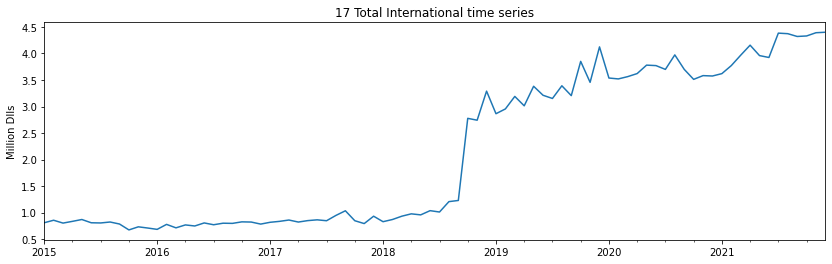

20 Total 401k


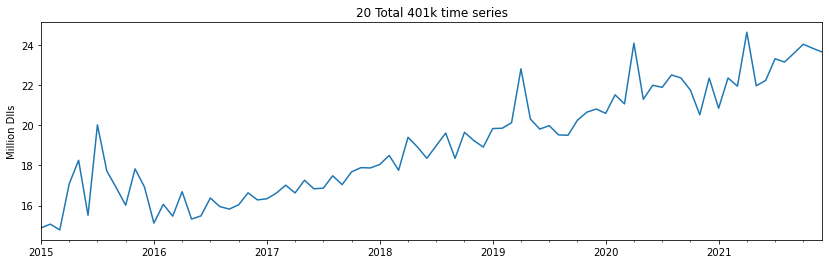

31 HR Solutions (excl PEO)


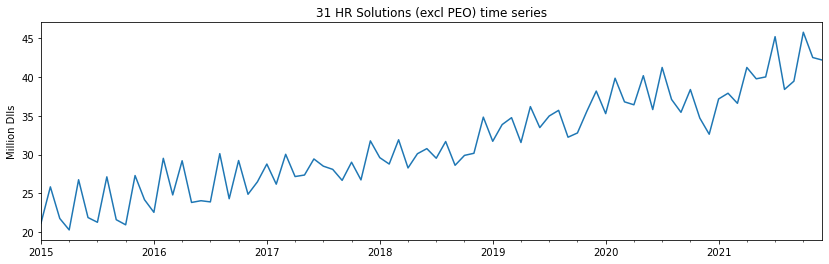

40 Total Online Services


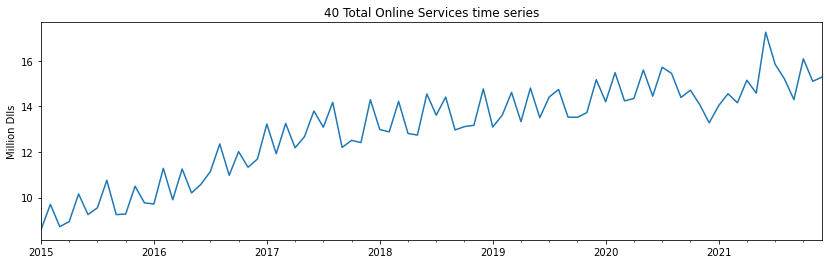

50 Other Managment Solutions


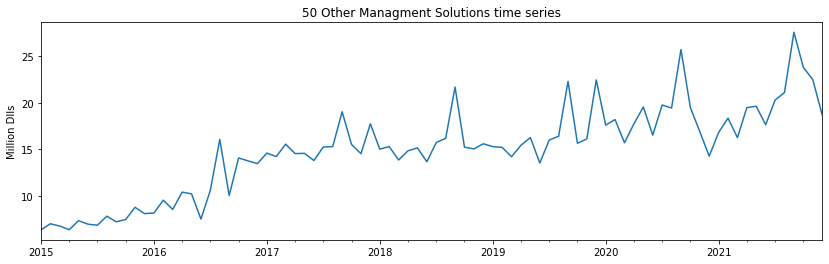

60 Total PEO


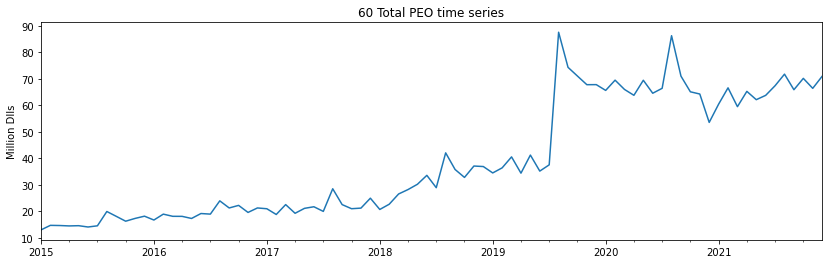

70 Total Insurance Services


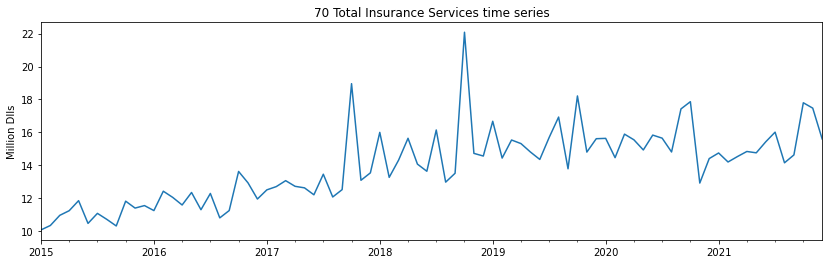

In [97]:
for c in df_month.columns:
    print(c)
    fig, ax = plt.subplots(figsize=(14,4))
    (df_month[c]/1000000).plot(title = c + ' time series', xlabel='', ylabel='Million Dlls', ax=ax)
    #sns.lineplot(data=df_month[c])
    plt.show()

In [58]:
total_revenue = df_month.sum(axis=1)

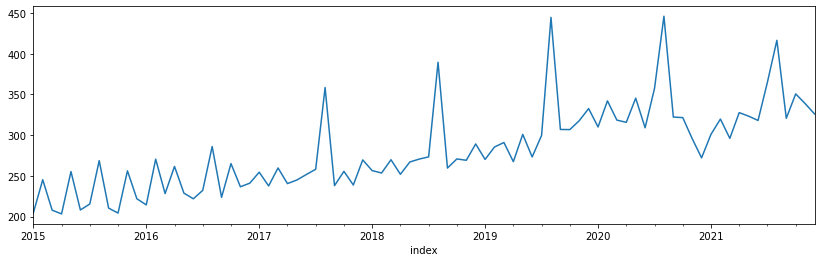

In [59]:
fig, ax = plt.subplots(figsize=(14,4))
(total_revenue/1000000).plot()
plt.show()

## Participation each item

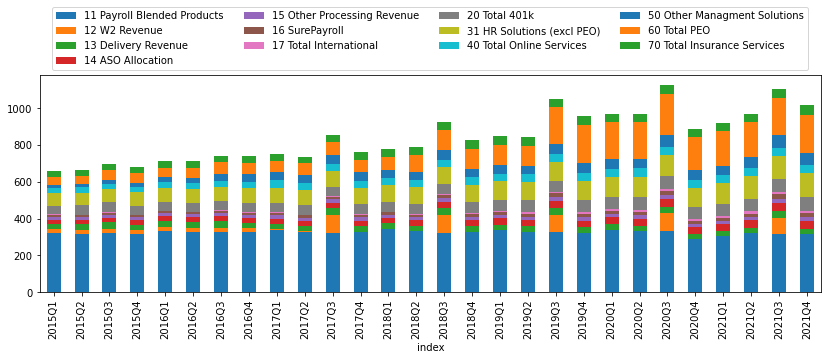

In [60]:
fig, ax = plt.subplots(figsize=(14,4))
(df_month/1000000).resample('Q').sum().plot.bar(stacked=True, ax=ax, legend=False)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=4)
plt.show()

In [88]:
rev_part_y = ((df_month).resample('Y').sum().divide(total_revenue.resample('Y').sum(), axis=0)*100).round(2)

In [89]:
rev_part_y

,11 Payroll Blended Products,12 W2 Revenue,13 Delivery Revenue,14 ASO Allocation,15 Other Processing Revenue,16 SurePayroll,17 Total International,20 Total 401k,31 HR Solutions (excl PEO),40 Total Online Services,50 Other Managment Solutions,60 Total PEO,70 Total Insurance Services
index,,,,,,,,,,,,,
2015,47.12,3.44,4.39,3.58,2.43,1.52,0.35,7.44,10.37,4.24,3.22,7.01,4.88
2016,45.02,3.26,4.16,3.68,2.53,1.59,0.32,6.57,10.75,4.55,4.55,8.08,4.94
2017,42.55,3.14,3.99,3.71,2.46,1.74,0.34,6.61,10.93,5.01,5.94,8.44,5.13
2018,39.92,3.07,3.70,3.71,2.25,1.79,0.54,6.79,10.96,4.88,5.64,11.29,5.45
2019,35.60,2.64,3.29,3.81,2.12,1.80,1.08,6.58,11.12,4.54,5.38,16.98,5.04
2020,32.78,2.41,3.01,3.88,2.00,1.92,1.11,6.62,11.22,4.45,5.58,20.35,4.69
2021,31.56,2.19,2.88,4.22,1.88,2.11,1.24,6.88,12.14,4.53,6.05,19.73,4.60


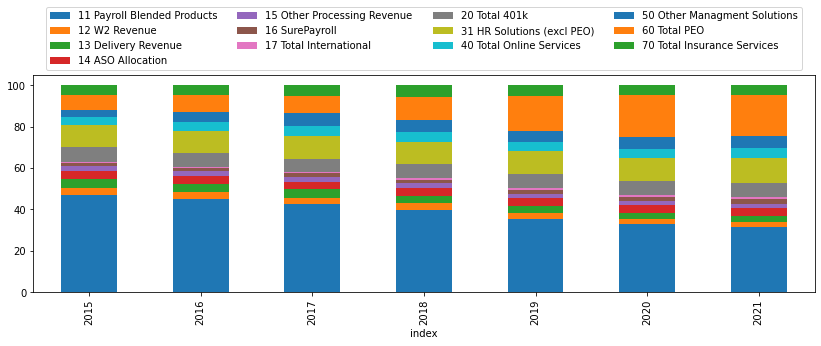

In [92]:
fig, ax = plt.subplots(figsize=(14,4))
rev_part_y.plot.bar(stacked=True,ax=ax, legend=False)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=4)
plt.show()

## Correlation matrix

In [62]:
rev_cor = df_month.corr()

In [71]:
rev_cor.round(2)

,11 Payroll Blended Products,12 W2 Revenue,13 Delivery Revenue,14 ASO Allocation,15 Other Processing Revenue,16 SurePayroll,17 Total International,20 Total 401k,31 HR Solutions (excl PEO),40 Total Online Services,50 Other Managment Solutions,60 Total PEO,70 Total Insurance Services
11 Payroll Blended Products,1.00,-0.06,0.26,0.27,0.24,0.16,-0.07,-0.05,0.26,0.24,0.03,-0.07,0.07
12 W2 Revenue,-0.06,1.00,0.74,0.00,0.58,0.03,0.01,0.02,0.01,0.10,0.02,0.17,-0.08
13 Delivery Revenue,0.26,0.74,1.00,0.09,0.76,-0.04,-0.02,-0.00,0.08,0.13,0.04,0.11,-0.15
14 ASO Allocation,0.27,0.00,0.09,1.00,0.33,0.79,0.89,0.87,1.00,0.90,0.80,0.87,0.65
15 Other Processing Revenue,0.24,0.58,0.76,0.33,1.00,0.22,0.22,0.22,0.33,0.37,0.41,0.38,0.19
16 SurePayroll,0.16,0.03,-0.04,0.79,0.22,1.00,0.72,0.74,0.79,0.75,0.68,0.70,0.59
17 Total International,-0.07,0.01,-0.02,0.89,0.22,0.72,1.00,0.90,0.89,0.77,0.71,0.92,0.66
20 Total 401k,-0.05,0.02,-0.00,0.87,0.22,0.74,0.90,1.00,0.88,0.79,0.74,0.86,0.67
31 HR Solutions (excl PEO),0.26,0.01,0.08,1.00,0.33,0.79,0.89,0.88,1.00,0.91,0.82,0.87,0.67
40 Total Online Services,0.24,0.10,0.13,0.90,0.37,0.75,0.77,0.79,0.91,1.00,0.85,0.79,0.70


<ipython-input-73-e97da9029b9c>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


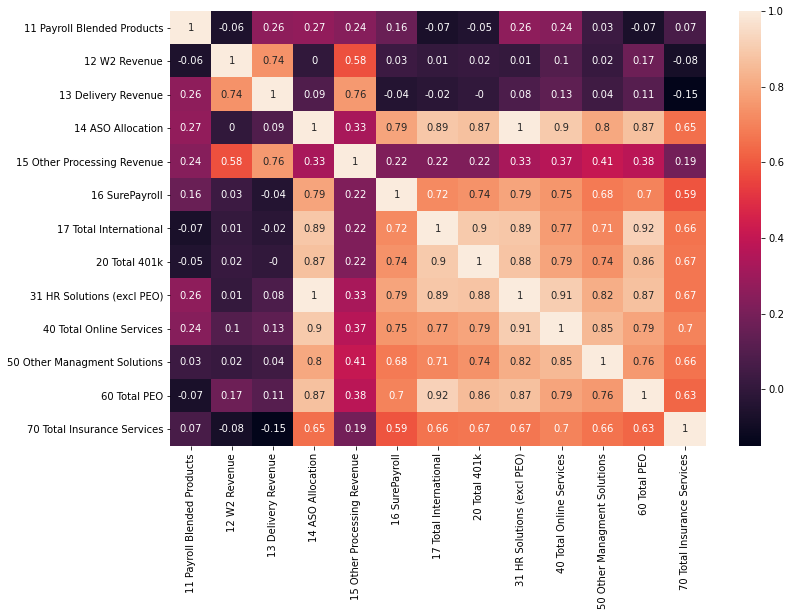

In [73]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(rev_cor.round(2), annot=True, ax=ax)
fig.show()